In [373]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
import warnings
warnings.filterwarnings('ignore')
import copy
from IPython.display import display
import plotly.express as px
import pickle
import warnings
warnings.filterwarnings('ignore')

# Plot Style
plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 10
sns.set_theme(style='darkgrid', palette='pastel', )
plt.rcParams['figure.facecolor'] = 'e7fff7' #https://www.colorhexa.com/ffe5b4
subplot_fontsize = 15
mainplot_fontsize = 20
scatterpoint_fontsize = 20

# Set the max columns to None to display all rows and columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)



def data_prep(start_date, end_date):
    df = yf.download('AMZN',start_date,end_date)
    APPL = yf.download('AAPL',start_date,end_date)
    MSFT = yf.download('MSFT',start_date,end_date)
    GOOG = yf.download('GOOG',start_date,end_date)
    VIX = yf.download("^VIX", start_date,end_date)
    usdx = yf.download('DX-Y.NYB', start_date,end_date)
    xlk = yf.download('XLK', start_date, end_date)
    onln = yf.download('ONLN', start_date, end_date)
    usd_eur = yf.download('EUR=X', start_date, end_date)

# (['APPL', 'MSFT', 'USDX', 'XLK', 'ONLN', 'USD_EUR', 'RSI', 'EMA12',
#       'EMA26', 'MACD']


    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    df['APPL'] = APPL['Close']
    df['MSFT'] = MSFT['Close']
    #df['GOOG'] = GOOG['Close']
    #df['VIX'] = VIX['Close']
    df['USDX'] = usdx['Close']
    df['XLK'] = xlk['Close']
    df['ONLN'] = onln['Close']
    df['USD_EUR'] = usd_eur['Close']

    df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

    ema12 = df['Close'].ewm(span=12, adjust=False).mean()
    ema26 = df['Close'].ewm(span=26, adjust=False).mean()

    macd = ema12 - ema26

    df['EMA12'] = ema12
    df['EMA26'] = ema26
    df['MACD'] = macd

    dff = pd.read_csv('dff.csv')
    dff['Date'] = pd.to_datetime(dff['DATE'])
    dff.drop(['DATE'],axis=1, inplace=True)
    df = df.reset_index()
    df['Date'] = pd.to_datetime(df['Date'])
    df = pd.merge(dff, df, on='Date')

    

    print(df.info)
    df.columns = df.columns.str.replace(' ','_')
    df = df.dropna()
    dates = pd.DataFrame(df['Date'])
    df.drop(['Date'],axis=1,inplace=True)
    df.drop(['Open', 'High', 'Low', 'Adj_Close'], axis=1, inplace=True)
    y_data = df['Close']
    df_copy = copy.deepcopy(df)
    df.drop(['Close'], axis=1, inplace=True)
    X_data = df
    return X_data,y_data, dates,X_data, y_data,df_copy

start_date = '2021-01-01'
end_date = '2023-04-05'
X, y, dates,X_data,Y_data,Data = data_prep(start_date, end_date)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

if X.shape[0] > 0 and y.shape[0] > 0:
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    y_scaler = MinMaxScaler()
    y = y_scaler.fit_transform(y.values.reshape(-1, 1))
else:
    print("Insufficient data for MinMaxScaler")

print(dates)


# with open('x_scaler_2years_74.pkl', 'rb') as f:
#     scaler = pickle.load(f)
#     X = scaler.fit_transform(X)

# with open('y_scaler_2years_74.pkl', 'rb') as f:
#     y_scaler = pickle.load(f)
#     y = y_scaler.fit_transform(y.values.reshape(-1, 1))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method DataFrame.info of       DFF       Date        Open        High         Low       Close  \
0    0.09 2021-01-04  163.500000  163.600006  157.201004  159.331497   
1    0.09 2021-01-05  158.300507  161.169006  158.253006  160.925507   
2    0.09 2021-01-06  157.324005  159.875504  156.557999  156.919006   
3    0.09 2021-01-07  157.850006  160.427002  157.750000  1

In [374]:
Data.describe()


,DFF,Close,Volume,APPL,MSFT,USDX,XLK,ONLN,USD_EUR,RSI,EMA12,EMA26,MACD
count,554.000000,554.000000,5.540000e+02,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000,554.000000
mean,1.325433,140.648736,7.130240e+07,148.341967,271.838791,99.045920,143.598123,52.761155,0.904233,48.566297,141.233374,142.011136,-0.777762
std,1.682821,30.368070,2.888920e+07,14.904057,30.360887,6.728763,13.474205,20.311212,0.060168,11.468004,29.614123,28.696570,3.357316
min,0.050000,81.820000,3.360600e+07,116.360001,214.250000,89.639999,116.559998,26.120001,0.816387,21.168752,85.130379,87.810099,-12.431501
25%,0.080000,112.462502,5.285292e+07,137.165005,246.869995,92.705002,132.914997,33.427499,0.847908,40.457103,113.885980,117.153208,-2.797065
50%,0.100000,152.774750,6.416500e+07,148.114998,265.705002,97.264999,141.730003,47.445000,0.895140,47.524693,154.007539,155.472040,-0.818563
75%,2.330000,166.403500,8.083350e+07,157.960007,294.367508,104.517498,153.694996,72.317499,0.948022,57.290086,166.095544,167.003593,1.465604
max,4.830000,186.570496,2.726620e+08,182.009995,343.109985,114.110001,176.649994,92.519997,1.042080,77.264764,181.298717,178.839491,7.141339


In [375]:
print(dates)

          Date
13  2021-01-22
14  2021-01-25
15  2021-01-26
16  2021-01-27
17  2021-01-28
18  2021-01-29
19  2021-02-01
20  2021-02-02
21  2021-02-03
22  2021-02-04
23  2021-02-05
24  2021-02-08
25  2021-02-09
26  2021-02-10
27  2021-02-11
28  2021-02-12
29  2021-02-16
30  2021-02-17
31  2021-02-18
32  2021-02-19
33  2021-02-22
34  2021-02-23
35  2021-02-24
36  2021-02-25
37  2021-02-26
38  2021-03-01
39  2021-03-02
40  2021-03-03
41  2021-03-04
42  2021-03-05
43  2021-03-08
44  2021-03-09
45  2021-03-10
46  2021-03-11
47  2021-03-12
48  2021-03-15
49  2021-03-16
50  2021-03-17
51  2021-03-18
52  2021-03-19
53  2021-03-22
54  2021-03-23
55  2021-03-24
56  2021-03-25
57  2021-03-26
58  2021-03-29
59  2021-03-30
60  2021-03-31
61  2021-04-01
62  2021-04-05
63  2021-04-06
64  2021-04-07
65  2021-04-08
66  2021-04-09
67  2021-04-12
68  2021-04-13
69  2021-04-14
70  2021-04-15
71  2021-04-16
72  2021-04-19
73  2021-04-20
74  2021-04-21
75  2021-04-22
76  2021-04-23
77  2021-04-26
78  2021-0

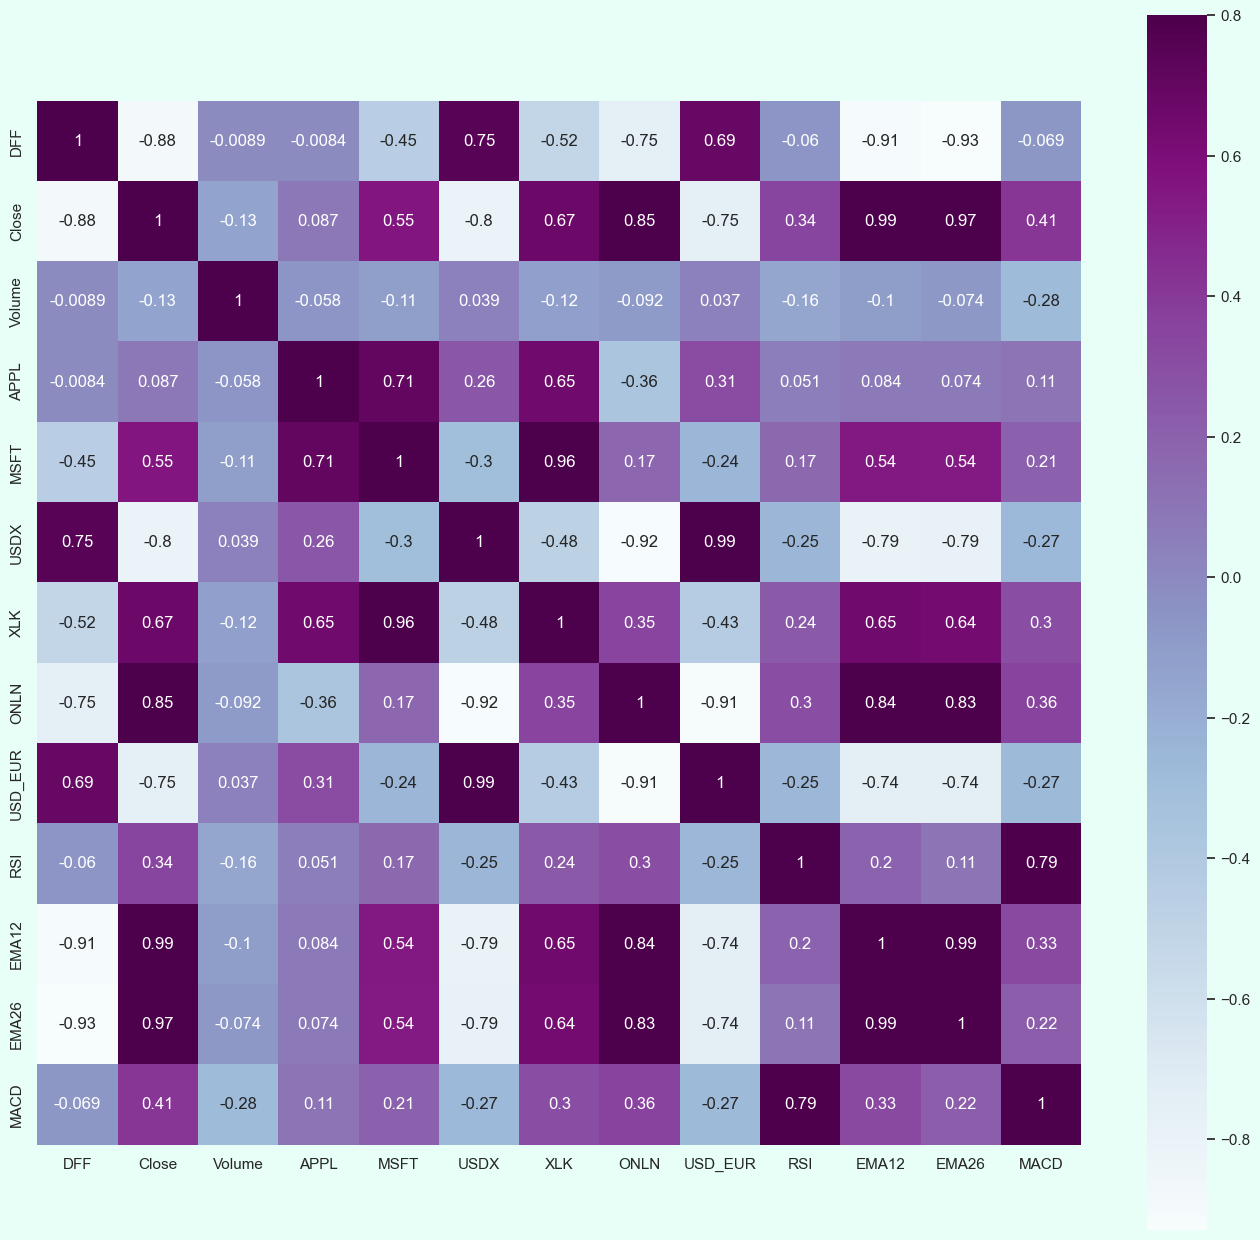

In [376]:
model_matrix_fig = Data.corr()
plt.figure(figsize=(15,15)) 
sns.heatmap(model_matrix_fig, vmax=.8, square=True, cmap="BuPu",annot=True);
plt.show()

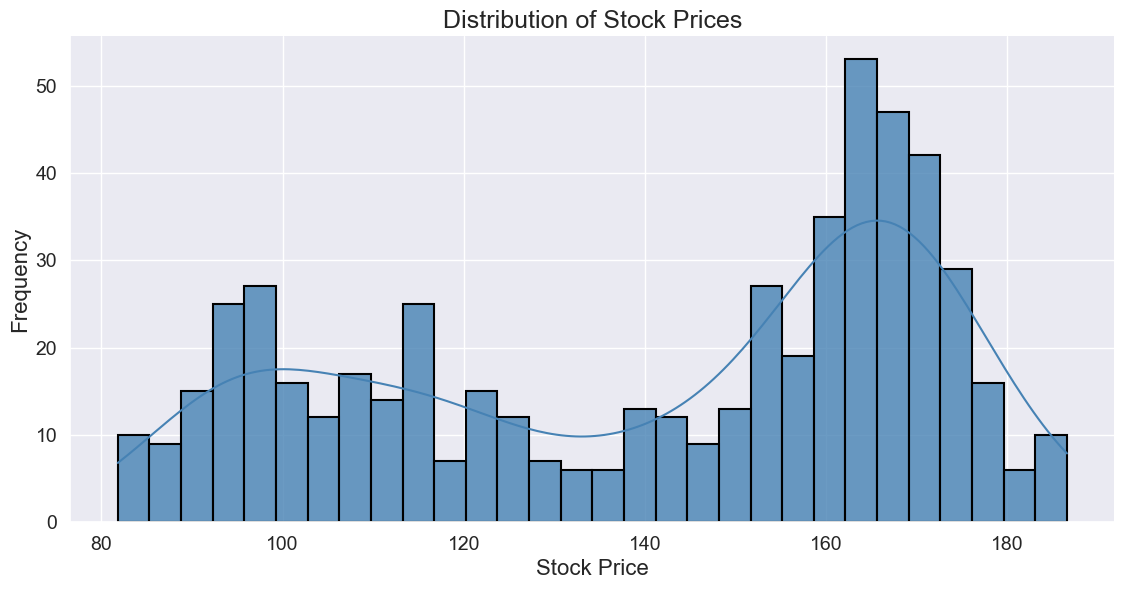

In [377]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style and font scale
sns.set_style("whitegrid")
sns.set(font_scale=1.2)

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(Y_data, kde=True, color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5, bins=30)

# Customize the plot's appearance
plt.xlabel("Stock Price", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.title("Distribution of Stock Prices", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove the top and right spines for a cleaner look
sns.despine()

# Show the plot
plt.show()


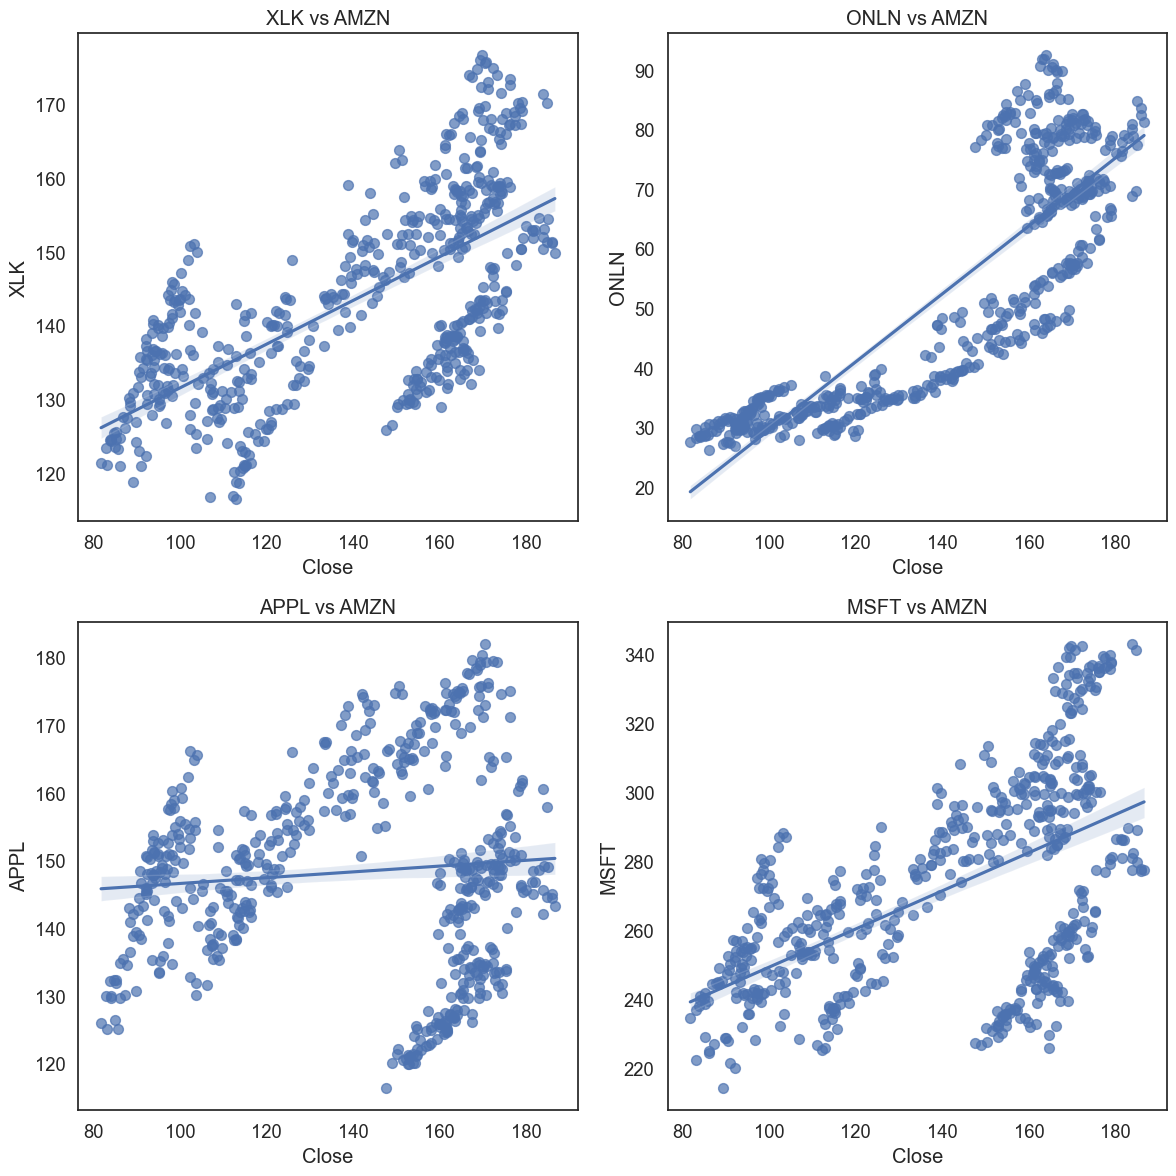

In [378]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have a DataFrame called 'Data' containing the features and the target variable.
# If not, replace 'Data' with your DataFrame name.

# Select the columns of interest
columns_of_interest = ['XLK', 'ONLN', 'APPL', 'MSFT', 'Close']
data_subset = Data[columns_of_interest]

# Set the style and font scale
sns.set(style="white", font_scale=1.2)

# Create a 2x2 grid of scatter plots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Plot each feature against the 'Close' column
for i, col in enumerate(columns_of_interest[:-1]):
    sns.regplot(ax=axes[i], x='Close', y=col, data=data_subset, scatter_kws=dict(s=50, edgecolor="b", linewidth=1, alpha=0.7))
    axes[i].set_title(f"{col} vs AMZN")

# Adjust the layout
plt.tight_layout()

# Show the scatter plots
plt.show()


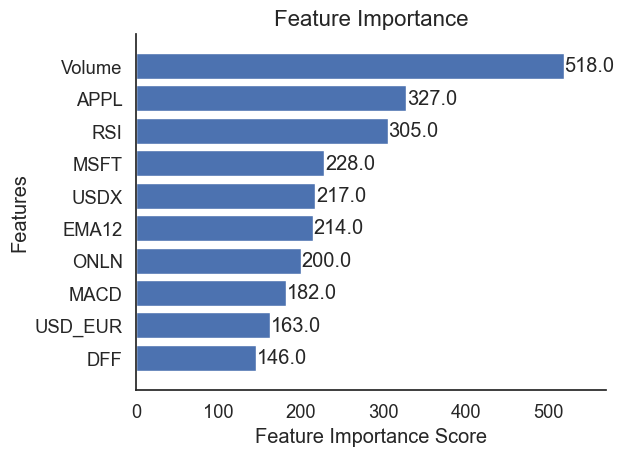

In [379]:
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

# Fit XGBoost model
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_data, Y_data)

# Plot feature importance
xgb.plot_importance(xgb_model,
                    importance_type='weight',  # Change to 'weight' or 'cover' if desired
                    xlabel='Feature Importance Score',
                    ylabel='Features',
                    show_values=True,  # Change to True if desired
                    height=0.8,
                    max_num_features=10,  # Change to adjust number of features displayed
                    grid=False)
plt.title('Feature Importance', fontsize=16)
plt.tight_layout()
sns.despine()
plt.show()


In [391]:
train_size = int(len(X) * 0.65)
train_X, test_X = X[:train_size], X[train_size:]
train_Y, test_Y = y[:train_size], y[train_size:]

# Reshape the input data to 3D arrays
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(train_X.shape[1], train_X.shape[2
]), return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss=MeanSquaredError(), optimizer=Adam())

In [392]:
early_stop = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
history = model.fit(train_X, train_Y, epochs=150, batch_size=4, validation_data=(test_X, test_Y), callbacks=[early_stop], verbose=2, shuffle=False)


import pickle


# with open('lstm_model_2years_74.pkl', 'rb') as f:
#     model = pickle.load(f)
    

test_loss = model.evaluate(test_X, test_Y, verbose=0)
yhat = model.predict(test_X)

yhat = y_scaler.inverse_transform(yhat)
test_Y = y_scaler.inverse_transform(test_Y)

print('Test loss: ', test_loss)

mae = mean_absolute_error(test_Y, yhat)
rmse = np.sqrt(mean_squared_error(test_Y, yhat))
r2 = r2_score(test_Y, yhat)

print('MAE: ', mae)
print('RMSE: ', rmse)
print('R²: ', r2)

Epoch 1/150
90/90 - 3s - loss: 0.1057 - val_loss: 0.0366 - 3s/epoch - 38ms/step
Epoch 2/150
90/90 - 0s - loss: 0.0120 - val_loss: 0.0149 - 287ms/epoch - 3ms/step
Epoch 3/150
90/90 - 0s - loss: 0.0081 - val_loss: 0.0115 - 271ms/epoch - 3ms/step
Epoch 4/150
90/90 - 0s - loss: 0.0064 - val_loss: 0.0135 - 270ms/epoch - 3ms/step
Epoch 5/150
90/90 - 0s - loss: 0.0092 - val_loss: 0.0141 - 310ms/epoch - 3ms/step
Epoch 6/150
90/90 - 0s - loss: 0.0062 - val_loss: 0.0179 - 276ms/epoch - 3ms/step
Epoch 7/150
90/90 - 0s - loss: 0.0064 - val_loss: 0.0229 - 269ms/epoch - 3ms/step
Epoch 8/150
90/90 - 0s - loss: 0.0063 - val_loss: 0.0263 - 273ms/epoch - 3ms/step
Epoch 9/150
90/90 - 0s - loss: 0.0055 - val_loss: 0.0340 - 267ms/epoch - 3ms/step
Epoch 10/150
90/90 - 0s - loss: 0.0052 - val_loss: 0.0343 - 269ms/epoch - 3ms/step
Epoch 11/150
90/90 - 0s - loss: 0.0052 - val_loss: 0.0402 - 270ms/epoch - 3ms/step
Epoch 12/150
90/90 - 0s - loss: 0.0041 - val_loss: 0.0485 - 270ms/epoch - 3ms/step
Epoch 13/150
90

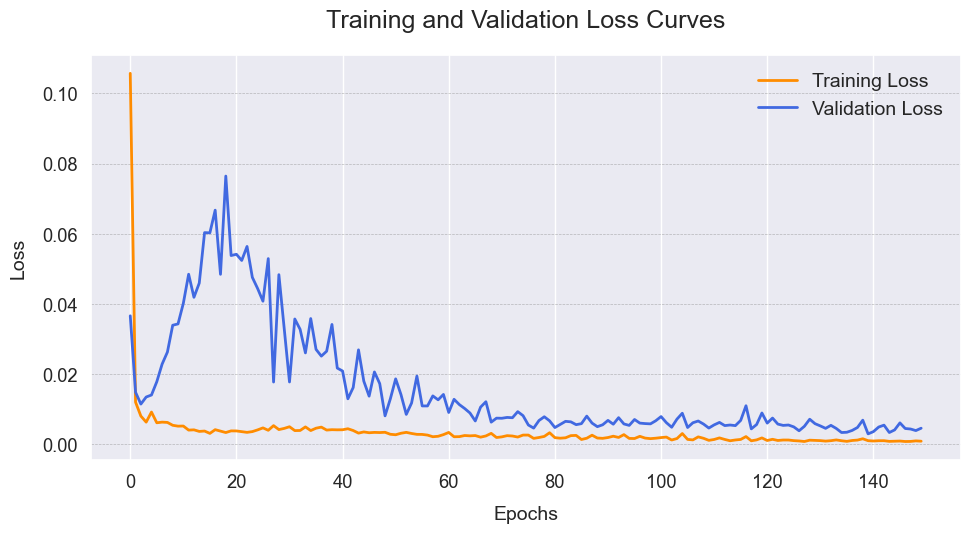

In [393]:





import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(10, 5))
sns.set(style="darkgrid", font_scale=1.2)

# Plot the training and validation loss curves
plt.plot(history.history['loss'], label="Training Loss", linewidth=2, color='darkorange')
plt.plot(history.history['val_loss'], label="Validation Loss", linewidth=2, color='royalblue')

# Add labels and title
plt.xlabel("Epochs", fontsize=14, labelpad=10)
plt.ylabel("Loss", fontsize=14, labelpad=10)
plt.title("Training and Validation Loss Curves", fontsize=18, pad=20)

# Customize legend
plt.legend(fontsize=14, loc='upper right')

# Add horizontal gridlines
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()


In [394]:
train_loss = model.evaluate(train_X, train_Y, verbose=0)
pred_train = model.predict(train_X)

yhat_train = y_scaler.inverse_transform(pred_train)

train_pred_Y = y_scaler.inverse_transform(train_Y)

print('Train loss: ', train_loss)

mae_train = mean_absolute_error(train_pred_Y, yhat_train)
rmse_train = np.sqrt(mean_squared_error(train_pred_Y, yhat_train))
r2_train = r2_score(train_pred_Y, yhat_train)

print('MAE: ', mae_train)
print('RMSE: ', rmse_train)
print('R²: ', r2_train)

12/12 [==============================] - 0s 2ms/step
Train loss:  0.0005461930995807052
MAE:  1.9463337580362956
RMSE:  2.4480996719574675
R²:  0.9829557076791705


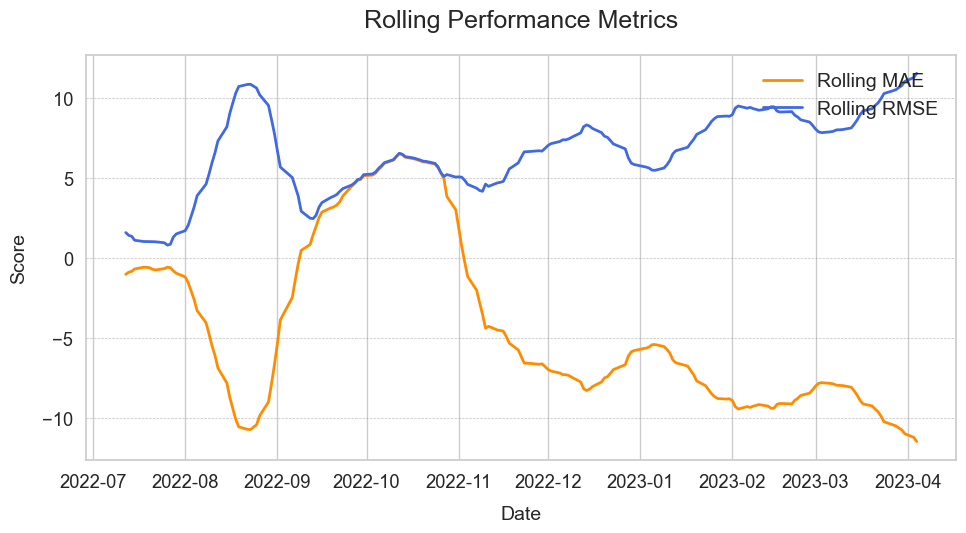

In [397]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define the rolling window size and calculate the errors
window_size = 10
errors = test_Y.flatten() - yhat.flatten()

# Calculate the rolling metrics
rolling_mae = pd.Series(errors).rolling(window=window_size).mean()
rolling_rmse = pd.Series(errors).rolling(window=window_size).apply(lambda x: np.sqrt(np.mean(x**2)))

# Set the figure size and style
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid", font_scale=1.2)

# Plot the rolling metrics
plt.plot(dates[train_size:], rolling_mae, label='Rolling MAE', linewidth=2, color='darkorange')
plt.plot(dates[train_size:], rolling_rmse, label='Rolling RMSE', linewidth=2, color='royalblue')

# Add labels and title
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Score', fontsize=14, labelpad=10)
plt.title('Rolling Performance Metrics', fontsize=18, pad=20)

# Customize legend
plt.legend(fontsize=14, loc='upper right')

# Add horizontal gridlines
plt.grid(axis='y', color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the plot
plt.show()


Mean error: -4.418902800255215
Median error: -6.298480987548828
Standard deviation of errors: 5.584473653409924
Skewness: 0.6647182720763759


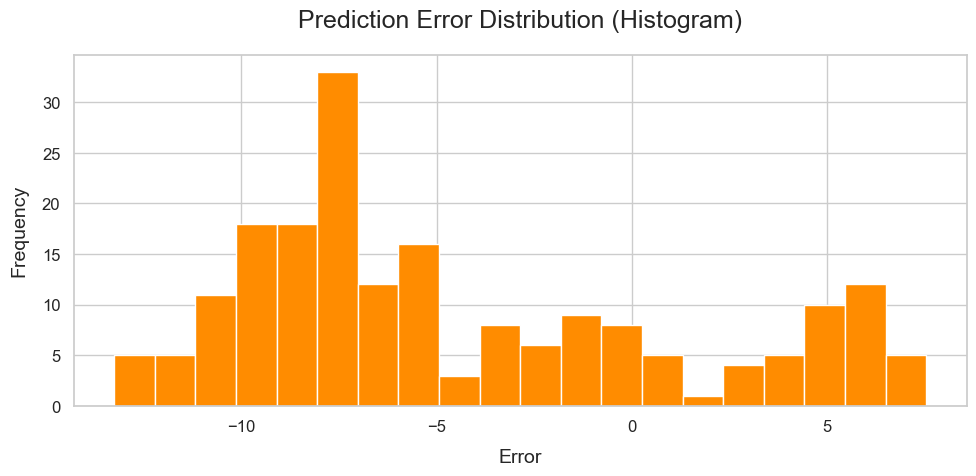

In [398]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate error statistics
mean_error = np.mean(errors)
median_error = np.median(errors)
std_error = np.std(errors)
skewness = np.mean((errors - mean_error) ** 3) / (std_error ** 3)

# Print error statistics
print("Mean error:", mean_error)
print("Median error:", median_error)
print("Standard deviation of errors:", std_error)
print("Skewness:", skewness)

# Histogram
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid", font_scale=1.2)
plt.hist(errors, bins=20, color='darkorange')
plt.title('Prediction Error Distribution (Histogram)', fontsize=18, pad=20)
plt.xlabel('Error', fontsize=14, labelpad=10)
plt.ylabel('Frequency', fontsize=14, labelpad=10)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


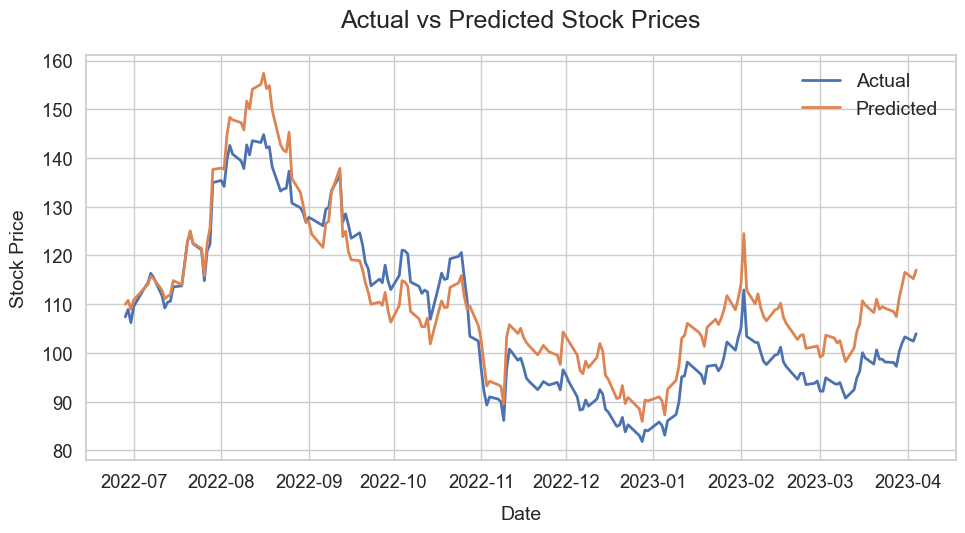

In [399]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert date column to datetime object
dates['Date'] = pd.to_datetime(dates['Date'])

# Set the figure size and style
plt.figure(figsize=(10, 5))
sns.set(style="whitegrid", font_scale=1.2)

# Plot the actual and predicted stock prices
plt.plot(dates[train_size:]['Date'], test_Y, label="Actual", linewidth=2)
plt.plot(dates[train_size:]['Date'], yhat, label="Predicted", linewidth=2)

# Add labels and title
plt.xlabel("Date", fontsize=14, labelpad=10)
plt.ylabel("Stock Price", fontsize=14, labelpad=10)
plt.title("Actual vs Predicted Stock Prices", fontsize=18, pad=20)

# Customize legend
plt.legend(fontsize=14)

# Show the plot
plt.show()


In [400]:
residuals = test_Y - yhat
std_residuals = np.std(residuals, ddof=1)

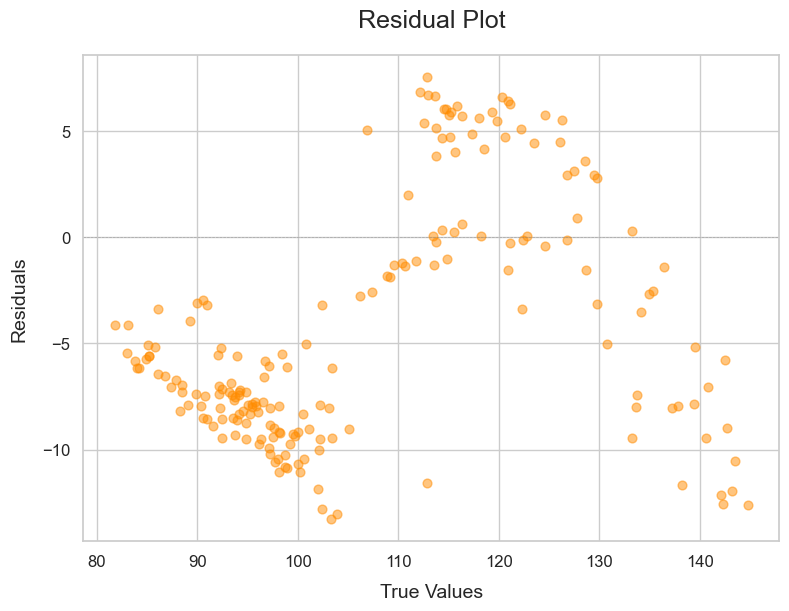

In [401]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Plot the residuals vs true values
residuals = test_Y - yhat
plt.scatter(test_Y, residuals, s=40, alpha=0.5, color='darkorange')

# Add a horizontal line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

# Add labels and title
plt.xlabel('True Values', fontsize=14, labelpad=10)
plt.ylabel('Residuals', fontsize=14, labelpad=10)
plt.title('Residual Plot', fontsize=18, pad=20)

# Customize tick labels
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()


In [402]:
from scipy import stats

def calculate_confidence_intervals(predictions, std_residuals, confidence_levels):
    intervals = []
    for conf_level in confidence_levels:
        z_score = stats.norm.ppf(1 - (1 - conf_level) / 2)
        interval = z_score * std_residuals
        lower_bound = predictions - interval
        upper_bound = predictions + interval
        intervals.append((lower_bound, upper_bound))
    return intervals


In [403]:

from pmdarima.arima import auto_arima
def generate_future_features_arima(X_data, n_steps):
    future_features = []
    for i in range(X_data.shape[1]):
        arima_model = auto_arima(X_data.iloc[:, i], suppress_warnings=True, seasonal=False, stepwise=True)
        forecast = arima_model.predict(n_periods=n_steps)
        future_features.append(forecast)
    return np.array(future_features).T     # List is 1D. So we converted to 2D with an array. But its column first then row [[1,2,3],[4,5,6],[7,8,9]]
# But for LSTM we need it to be row wise like Excel . so we transpose it to match LSTM dims

In [404]:
import pandas_market_calendars as mcal
from pandas.tseries.offsets import BDay

def generate_trading_days(start_date, n_days):
    nyse = mcal.get_calendar('NYSE')
    trading_days = nyse.valid_days(start_date=start_date, end_date=start_date + BDay(n_days * 2)) # Business dayscounted. Multiplied by 2 to ensure we have enough business days
    return trading_days[:n_days]

n_future_days = 10
last_date = dates.iloc[-1].values[0]
future_dates = generate_trading_days(last_date, n_future_days)

print(future_dates)


DatetimeIndex(['2023-04-04 00:00:00+00:00', '2023-04-05 00:00:00+00:00',
               '2023-04-06 00:00:00+00:00', '2023-04-10 00:00:00+00:00',
               '2023-04-11 00:00:00+00:00', '2023-04-12 00:00:00+00:00',
               '2023-04-13 00:00:00+00:00', '2023-04-14 00:00:00+00:00',
               '2023-04-17 00:00:00+00:00', '2023-04-18 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)


In [405]:
# # Generate future feature values
# n_future_steps = 10
# future_dates = pd.date_range(dates.iloc[-1, 0], periods=n_future_steps + 1, closed='right')

# Get column names from the original DataFrame
column_names = X_data.columns


# Generate future feature values using ARIMA
future_features = generate_future_features_arima(X_data, n_future_days)

# Scale the future feature values
scaled_future_features = scaler.transform(future_features)


# Reshape the future feature values to a 3D array
scaled_future_features = scaled_future_features.reshape((scaled_future_features.shape[0], 1, scaled_future_features.shape[1]))

# Predict future closing prices
future_closing_prices = model.predict(scaled_future_features)

# Inverse transform the predicted closing prices
future_closing_prices = y_scaler.inverse_transform(future_closing_prices)

# Display the future closing prices
future_closing_prices_df = pd.DataFrame(future_closing_prices, index=future_dates, columns=['Predicted_Close'])
print(future_closing_prices_df)


1/1 [==============================] - 0s 22ms/step
                           Predicted_Close
2023-04-04 00:00:00+00:00       116.970062
2023-04-05 00:00:00+00:00       116.723854
2023-04-06 00:00:00+00:00       116.461861
2023-04-10 00:00:00+00:00       116.205620
2023-04-11 00:00:00+00:00       115.947586
2023-04-12 00:00:00+00:00       115.694946
2023-04-13 00:00:00+00:00       115.457672
2023-04-14 00:00:00+00:00       115.233429
2023-04-17 00:00:00+00:00       115.015984
2023-04-18 00:00:00+00:00       114.808372


In [406]:
confidence_levels = [0.90, 0.95, 0.99]
future_intervals = calculate_confidence_intervals(future_closing_prices, std_residuals, confidence_levels)


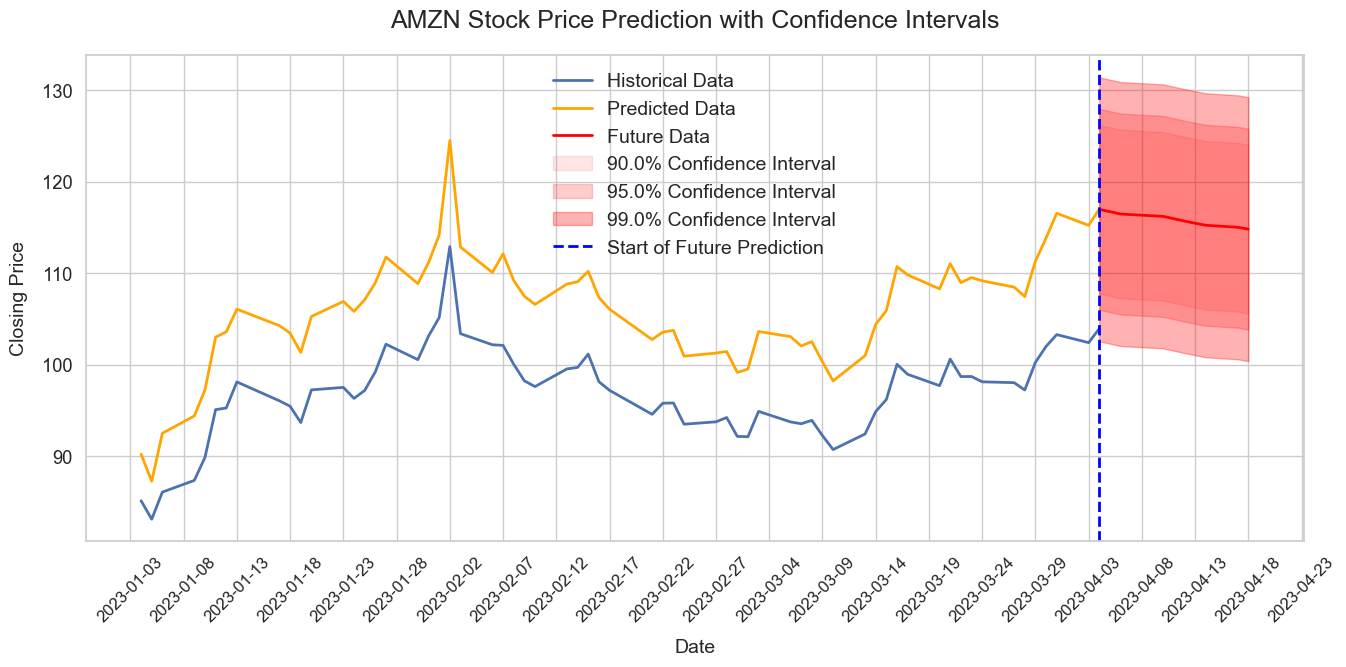

In [407]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Define the number of months to display
n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)

# Filter dates and closing prices
mask = dates['Date'] >= start_date 
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1)]

predicted_mask = dates.iloc[-yhat.shape[0]:]['Date'] >= start_date
filtered_yhat = yhat[predicted_mask.to_numpy().reshape(-1)]
filtered_predicted_dates = dates.iloc[-yhat.shape[0]:][predicted_mask]

# Set the figure size and style
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Plot the historical, predicted, and future closing prices
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data', linewidth=2)
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange', linewidth=2)
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red', linewidth=2)

# Plot the confidence intervals
for i, conf_level in enumerate(confidence_levels):
    lower_bound, upper_bound = future_intervals[i]
    plt.fill_between(future_dates, lower_bound.ravel(), upper_bound.ravel(), color='red', alpha=0.1 * (i + 1),
                     label=f'{conf_level * 100}% Confidence Interval')

# Add a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction', linewidth=2)

# Set x-axis ticks and labels
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45, fontsize=12)

# Add labels and title
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Closing Price', fontsize=14, labelpad=10)
plt.title('AMZN Stock Price Prediction with Confidence Intervals', fontsize=18, pad=20)

# Customize legend
plt.legend(fontsize=14)

# Show the plot
plt.show()


7/7 [==============================] - 0s 2ms/step


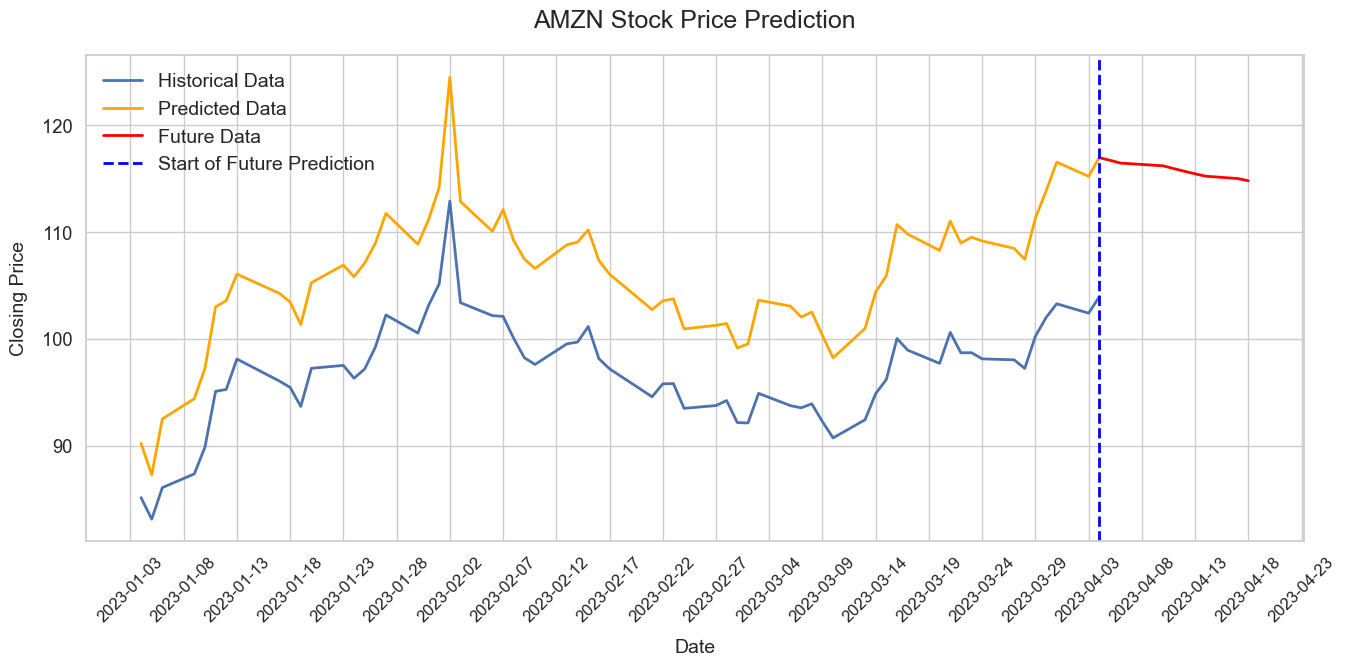

In [408]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# Predict on the test set
test_Y_pred = model.predict(test_X)

# Filter the data for the last 3 months
n_months = 3
start_date = dates.iloc[-1][0] - pd.DateOffset(months=n_months)
mask = dates['Date'] >= start_date 
filtered_dates = dates[mask]
filtered_y = y_scaler.inverse_transform(y)[mask.to_numpy().reshape(-1)]

# Filter the predicted data and extracted the DATES
predicted_mask = dates.iloc[-yhat.shape[0]:]['Date'] >= start_date
filtered_yhat = yhat[predicted_mask.to_numpy().reshape(-1)]
filtered_predicted_dates = dates.iloc[-yhat.shape[0]:][predicted_mask]

# Set the figure size and style
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Plot the historical, predicted, and future closing prices
plt.plot(filtered_dates['Date'], filtered_y, label='Historical Data', linewidth=2)
plt.plot(filtered_predicted_dates['Date'], filtered_yhat, label='Predicted Data', color='orange', linewidth=2)
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red', linewidth=2)

# Add a vertical line at the point of future prediction
plt.axvline(x=dates.iloc[-1][0], color='blue', linestyle='--', label='Start of Future Prediction', linewidth=2)

# Set x-axis ticks and labels
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45, fontsize=12)

# Add labels and title
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Closing Price', fontsize=14, labelpad=10)
plt.title('AMZN Stock Price Prediction', fontsize=18, pad=20)

# Customize legend
plt.legend(fontsize=14)

# Show the plot
plt.show()


In [412]:
# import pickle

# # Save the model to a file
# with open('lstm_model_2years_81.pkl', 'wb') as file:
#     pickle.dump(model, file)

# # Save the MinMaxScaler objects for X and y
# with open('x_scaler_2years_81.pkl', 'wb') as file:
#     pickle.dump(scaler, file)

# with open('y_scaler_2years_81.pkl', 'wb') as file:
#     pickle.dump(y_scaler, file)


# with open('history_81.pkl', 'wb') as f:
#     pickle.dump(history.history, f)



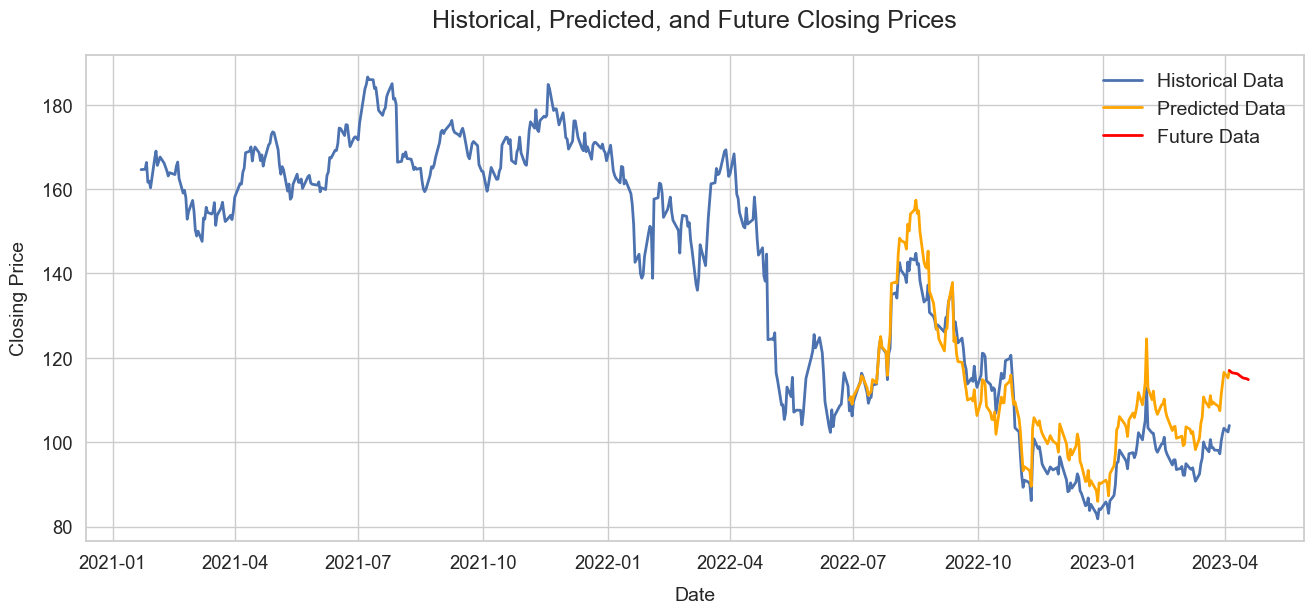

In [410]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size and style
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Plot the historical, predicted, and future closing prices
plt.plot(dates, y_scaler.inverse_transform(y), label='Historical Data', linewidth=2)
plt.plot(dates.iloc[-test_Y.shape[0]:], yhat, label='Predicted Data', color='orange', linewidth=2)
plt.plot(future_dates, future_closing_prices, label='Future Data', color='red', linewidth=2)

# Add labels and title
plt.xlabel('Date', fontsize=14, labelpad=10)
plt.ylabel('Closing Price', fontsize=14, labelpad=10)
plt.title('Historical, Predicted, and Future Closing Prices', fontsize=18, pad=20)

# Customize legend
plt.legend(fontsize=14)

# Show the plot
plt.show()


In [ ]:
print(yhat.shape)

(173, 1)


In [ ]:
# Confidence intervals
# Central tendencies
# 

In [ ]:
# tried via linear regression - > The residuals were not normally distributed. Lot of other factors impact LR. 
# Univariate LSTM - > Lot of other factors impact LR. 
# Correlation
# Scaling - Why was it imp to have scaling
    # How did you achieve scaling 
    # How is it benefiting right now
# WHy OHL was removed
# Model
# WHy trading days